In [1]:
%pylab inline 


Populating the interactive namespace from numpy and matplotlib


In [2]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from collections import Counter
import time
import progressbar as pb
from tqdm import tqdm
import os
import shutil
from empyrical import sortino_ratio, calmar_ratio, omega_ratio
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy, ActorCriticPolicy, FeedForwardPolicy
from stable_baselines.common.vec_env import SubprocVecEnv, VecEnv, VecEnvWrapper
from stable_baselines import A2C, PPO2
from stable_baselines.common.vec_env import DummyVecEnv
import tensorflow as tf
from trading_env import TradingEnv

In [3]:
# load the market data
input_source = np.load(open('data_eth.npy','rb'))
to_predict = np.load(open('data_eth_targets.npy','rb'))

to_predict = to_predict[3,:].reshape(-1)

input_source = input_source.T

In [4]:
is_orig = np.copy(input_source)
cp = int(0.8*len(input_source))
test_input_source = input_source[cp:, :]
test_to_predict = to_predict[cp:]
input_source = input_source[0:cp, :]
to_predict = to_predict[0:cp]

In [5]:
bars_per_episode = 1000
winlen = 1
traded_amt = 1
initial_balance = 10000000
commission = 0
slippage = 0.0

In [6]:
# multiprocess environment
#n_cpu = 16
#env = SubprocVecEnv([lambda: TradingEnv(input_source, to_predict,
#                                         winlen=winlen, bars_per_episode=bars_per_episode, traded_amt=traded_amt, initial_balance=initial_balance,
#                                         commission=commission, slippage=slippage) for i in range(n_cpu)])
env = TradingEnv(input_source, to_predict,
                 winlen=winlen, bars_per_episode=bars_per_episode, traded_amt=traded_amt, initial_balance=initial_balance,
                 commission=commission, slippage=slippage,
                 reward_type='sortino'
                 )
env = DummyVecEnv([lambda: env])

t = 0
# Custom MLP policy of two layers of size 32 each with tanh activation function
policy_kwargs = dict(act_fun=tf.nn.relu, net_arch=[128, 64])

#[shutil.rmtree('/home/peter/tblog/'+x) for x in os.listdir('/home/peter/tblog/') if x]
model = PPO2(MlpPolicy, env, n_steps=128, verbose=0, #nminibatches=1, 
             policy_kwargs=policy_kwargs, 
             gamma=0.8,#0.99,
             ent_coef=0.05,#0.01,
             learning_rate=0.00025,
             vf_coef=0.5,
             max_grad_norm=0.5,
             lam=0.95,
             tensorboard_log='/home/peter/tblog')
try:
    model.learn(total_timesteps=10_000_000)
    model.save("ppo2_trading")
except KeyboardInterrupt:
    pass

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


100%|██████████| 1000/1000 [00:00<00:00, 1092.22it/s]


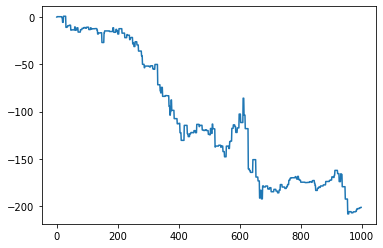

In [15]:
env = TradingEnv(test_input_source, test_to_predict,
                 winlen=winlen, bars_per_episode=bars_per_episode, traded_amt=traded_amt,
                 commission=commission, slippage=slippage
                 )
env = DummyVecEnv([lambda: env])

# visualize the behavior for one random episode
bars_per_episode = 1000

nstate = model.initial_state  # get the initial state vector for the reccurent network
#dones = np.zeros(nstate.shape[0])  # set all environment to not done
nstate=None

observation = env.envs[0].reset()#env.reset()
done = False
navs = []
acts = []
for i in tqdm(range(bars_per_episode)):
    action, nstate = model.predict([observation], state=nstate)
    acts.append(action)
    observation, reward, done, info = env.envs[0].step(action)#env.step(action)
    if done:
        break
    navs.append(env.get_attr('balance')[0])


kl = []
t = 0
for n in np.diff(np.vstack(navs).reshape(-1)):
    t = t + n
    kl.append(t)
plot(kl);

In [8]:
# calculate the likelihood of success for any given episode
try:
    l = 1000

    krl = []
    p = pb.ProgressBar(max_value=l)
    for i in range(l):
        p.update(i)
        observation = env.envs[0].reset()
        done = False
        navs = []
        for i in (range(bars_per_episode)):
            action, nstate = model.predict([observation], state=nstate)
            acts.append(action)
            observation, reward, done, info = env.envs[0].step(action)#env.step(action)
            navs.append(env.get_attr('balance')[0])
        kl = []
        t = 0
        for n in np.diff(np.vstack(navs).reshape(-1)):
            t = t + n
            kl.append(t)
        krl.append(kl[-1])
    p.finish()
except KeyboardInterrupt:
    pass

krl = np.array(krl)
print('Profit likelihood: %3.3f%%' % (100*(sum(krl > 0) / len(krl))))

 10% (109 of 1000) |##                   | Elapsed Time: 0:02:44 ETA:   0:16:17

Profit likelihood: 50.459%


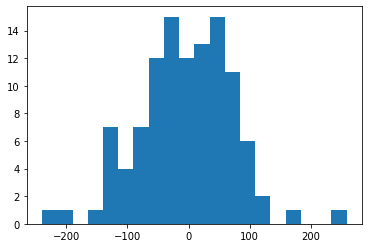

In [9]:
hist(krl,20);